# Main

## Refs
- https://github.com/tanjimin/grad-cam-pytorch-light/

## Imports

In [7]:
import cv2
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

## Utils

In [2]:

class InfoHolder():

    def __init__(self, heatmap_layer):
        self.gradient = None
        self.activation = None
        self.heatmap_layer = heatmap_layer

    def get_gradient(self, grad):
        self.gradient = grad

    def hook(self, model, input, output):
        output.register_hook(self.get_gradient)
        self.activation = output.detach()


In [3]:

def generate_heatmap(weighted_activation):
    raw_heatmap = torch.mean(weighted_activation, 0)
    heatmap = np.maximum(raw_heatmap.detach().cpu(), 0)
    heatmap /= torch.max(heatmap) + 1e-10
    return heatmap.numpy()


In [4]:

def superimpose(input_img, heatmap):
    img = cv2.cvtColor(input_img,cv2.COLOR_BGR2RGB)
    heatmap = cv2.resize(heatmap, (img.shape[0], img.shape[1]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = np.uint8(heatmap * 0.6 + img * 0.4)
    pil_img = cv2.cvtColor(superimposed_img,cv2.COLOR_BGR2RGB)
    return pil_img


In [5]:

def to_RGB(tensor):
    tensor = (tensor - tensor.min())
    tensor = tensor/(tensor.max() + 1e-10)
    image_binary = np.transpose(tensor.numpy(), (1, 2, 0))
    image = np.uint8(255 * image_binary)
    return image


In [68]:
def cam(model, input_tensor, heatmap_layer, truelabel=None):
    info = InfoHolder(heatmap_layer)
    hook = heatmap_layer.register_forward_hook(info.hook)

    output = model(input_tensor.unsqueeze(0))[0]
    output[torch.argmax(output)].backward()

    heatmap = generate_heatmap(info.gradient[0])
    weights = torch.mean(info.gradient, [0, 2, 3])
    activation = info.activation.squeeze(0)

    weighted_activation = torch.zeros(activation.shape)
    for idx, (weight, activation) in enumerate(zip(weights, activation)):
        weighted_activation[idx] = weight * activation

    heatmap = generate_heatmap(weighted_activation)
    input_image = to_RGB(input_tensor)

    return superimpose(input_image, heatmap)


In [64]:
def grad_cam(model, input_tensor, heatmap_layer, truelabel=None):
    info = InfoHolder(heatmap_layer)
    heatmap_layer.register_forward_hook(info.hook)
    
    output = model(input_tensor.unsqueeze(0))[0]
    truelabel = truelabel if truelabel else torch.argmax(output)

    output[truelabel].backward()

    weights = torch.mean(info.gradient, [0, 2, 3])
    activation = info.activation.squeeze(0)

    weighted_activation = torch.zeros(activation.shape)
    for idx, (weight, activation) in enumerate(zip(weights, activation)):
        weighted_activation[idx] = weight * activation

    heatmap = generate_heatmap(weighted_activation)
    input_image = to_RGB(input_tensor)

    return superimpose(input_image, heatmap)


## Demo

In [65]:
def cat_example(attribution_method=grad_cam):
    model = torchvision.models.resnet34(pretrained=True)
    model.eval()
    transform = transforms.Compose([
        transforms.Resize(240),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    heatmap_layer = model.layer4[2].conv2
    image = Image.open("./images/cat_dog.png")
    input_tensor = transform(image)
    boxer_label = 242
    image = attribution_method(model, input_tensor, heatmap_layer, boxer_label)
    plt.imshow(image)
    # disable axis and borders
    plt.axis('off')

    # plt.savefig('./images/boxer_grad-cam')

/Users/eragon/mambaforge/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/eragon/mambaforge/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


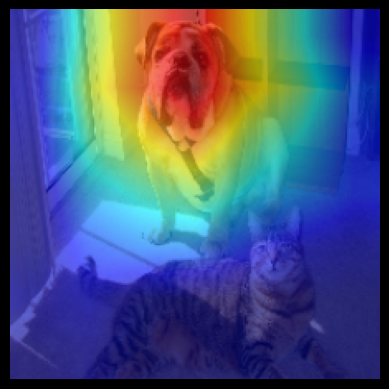

In [66]:
cat_example(grad_cam)

/Users/eragon/mambaforge/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/eragon/mambaforge/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


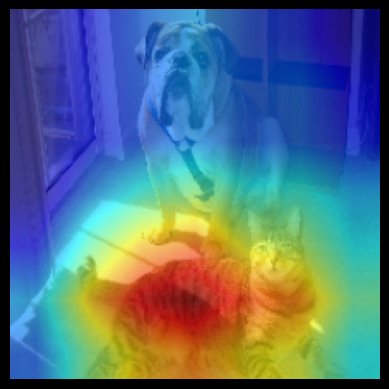

In [69]:
cat_example(cam)